## Basic KB-NUFFT Example

This notebook implements a basic KB-NUFFT example. It takes a Shepp-Logan phantom, applies the forward NUFFT, and then the adjoint NUFFT. An alternative processing path is to apply the density compensation function prior to adjoint NUFFT. Both of these examples are included here.

### Note

This notebook uses the shepp_logan_phantom from scikit-image, which is included in scikit-image v0.16. The standard Anaconda scikit-image as of this writing is 0.15. To use this notebook, you'll need to upgrade scikit-image to v0.16, e.g. ```conda install -c conda-forge scikit-image=0.16```.

### References

Fessler, J. A., & Sutton, B. P. (2003). Nonuniform fast Fourier transforms using min-max interpolation. IEEE transactions on signal processing, 51(2), 560-574.

Beatty, P. J., Nishimura, D. G., & Pauly, J. M. (2005). Rapid gridding reconstruction with a minimal oversampling ratio. IEEE transactions on medical imaging, 24(6), 799-808.

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from tfkbnufft import kbnufft_forward, kbnufft_adjoint
from tfkbnufft.kbnufft import KbNufftModule
from tfkbnufft.mri.dcomp_calc import calculate_radial_dcomp_tf, calculate_density_compensator

dtype = tf.float32

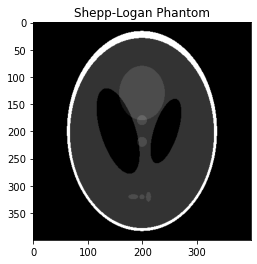

In [3]:
# create a simple shepp logan phantom and plot it
image = shepp_logan_phantom().astype(np.complex)
im_size = image.shape
plt.imshow(np.absolute(image))
plt.gray()
plt.title('Shepp-Logan Phantom')
plt.show()

In [4]:
# convert the phantom to a tensor and unsqueeze coil and batch dimension
image = tf.convert_to_tensor(image)[None, None, ...]
print('image shape: {}'.format(image.shape))

image shape: (1, 1, 400, 400)


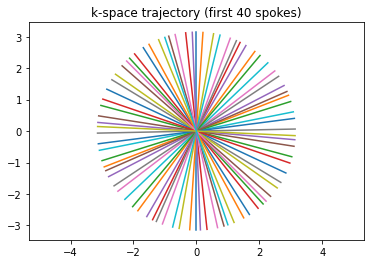

In [6]:
# create a k-space trajectory and plot it
spokelength = image.shape[-1] * 2
grid_size = (spokelength, spokelength)
nspokes = 405

ga = np.deg2rad(180 / ((1 + np.sqrt(5)) / 2))
kx = np.zeros(shape=(spokelength, nspokes))
ky = np.zeros(shape=(spokelength, nspokes))
ky[:, 0] = np.linspace(-np.pi, np.pi, spokelength)
for i in range(1, nspokes):
    kx[:, i] = np.cos(ga) * kx[:, i - 1] - np.sin(ga) * ky[:, i - 1]
    ky[:, i] = np.sin(ga) * kx[:, i - 1] + np.cos(ga) * ky[:, i - 1]
    
ky = np.transpose(ky)
kx = np.transpose(kx)

ktraj = np.stack((ky.flatten(), kx.flatten()), axis=0)

# plot the first 40 spokes
plt.plot(kx[:40, :].transpose(), ky[:40, :].transpose())
plt.axis('equal')
plt.title('k-space trajectory (first 40 spokes)')
plt.show()

In [7]:
# convert k-space trajectory to a tensor and unsqueeze batch dimension
ktraj = tf.convert_to_tensor(ktraj)[None, ...]
print('ktraj shape: {}'.format(ktraj.shape))

ktraj shape: (1, 2, 324000)


In [8]:
# create NUFFT objects, use 'ortho' for orthogonal FFTs
nufft_ob = KbNufftModule(im_size=im_size, grid_size=grid_size, norm='ortho')

print(nufft_ob)


KbNufftModule
----------------------------------------
   im_size: (400, 400)
   im_rank: 2
   grid_size: (800, 800)
   n_shift: (200, 200)
   numpoints: (6, 6)
   alpha: (14.04, 14.04)
   order: (0, 0)
   table: 2 arrays, lengths: (1024, 1024)
   scaling_coef: (400, 400) float64 array
   norm: ortho
   coil_broadcast: False
   matadj: False
   scaling_coef_tensor: (400, 400) <dtype: 'float64'> array
   n_shift_tensor: [200 200]
   grid_size_tensor: [800 800]
   im_size_tensor: [400 400]
   numpoints_tensor: [6. 6.]



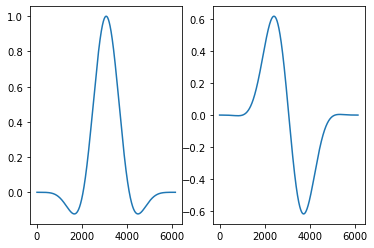

In [9]:
# plot the kernel
fig, axs = plt.subplots(1, 2)
axs.flat[0].plot(np.real(nufft_ob.table[0]))
axs.flat[1].plot(np.imag(nufft_ob.table[0]))
    
plt.show()

In [10]:
# %%debug
# calculate k-space data
kdata = kbnufft_forward(nufft_ob._extract_nufft_interpob())(image, ktraj)
# add some noise (robustness test)
siglevel = tf.reduce_mean(tf.math.abs(kdata))
kdata = kdata + tf.cast((siglevel/5) *tf.random.normal(kdata.shape, dtype=siglevel.dtype), kdata.dtype)

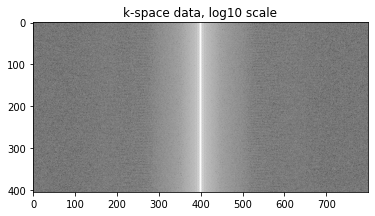

In [11]:
# plot the k-space data on log-scale
kdata_numpy = np.reshape(kdata.numpy(), (nspokes, spokelength))
plt.imshow(np.log10(np.absolute(kdata_numpy)))
plt.gray()
plt.title('k-space data, log10 scale')
plt.show()

In [14]:
# adjnufft back
# method 1: no density compensation (blurry image)
interpob = nufft_ob._extract_nufft_interpob()
nufft_adj = kbnufft_adjoint(interpob)
image_blurry = nufft_adj(kdata, ktraj)

# method 2: use density compensation
dcomp = calculate_radial_dcomp_tf(interpob, kbnufft_forward(interpob), nufft_adj, ktraj[0])[None, :]
dcomp_new = calculate_density_compensator(interpob, ktraj[0])[0]

image_sharp = nufft_adj(kdata * tf.cast(dcomp, kdata.dtype), ktraj)
image_sharp_new = nufft_adj(kdata * tf.cast(dcomp_new, kdata.dtype), ktraj)

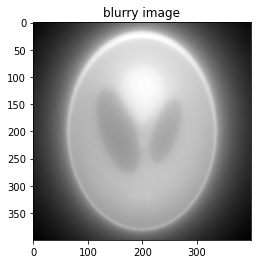

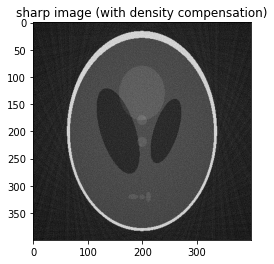

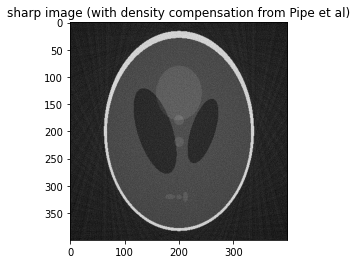

In [15]:
# show the images
image_blurry_numpy = np.squeeze(image_blurry.numpy())
image_sharp_numpy = np.squeeze(image_sharp.numpy())

plt.figure(0)
plt.imshow(np.absolute(image_blurry_numpy))
plt.gray()
plt.title('blurry image')


plt.figure(1)
plt.imshow(np.absolute(image_sharp_numpy))
plt.gray()
plt.title('sharp image (with density compensation)')


plt.figure(2)
plt.imshow(np.absolute(image_sharp_numpy))
plt.gray()
plt.title('sharp image (with density compensation from Pipe et al)')

plt.show()